In [24]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [25]:
import math
import tensorflow as tf

In [26]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=3):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


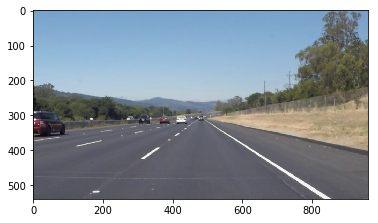

In [27]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [28]:
image_file = 'processed_solidWhiteCurve.jpg'
raw_image = mpimg.imread('test_images/solidWhiteRight.jpg')
imshape = raw_image.shape
imshape
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
this_image = grayscale(raw_image)

In [29]:
def region_of_interest(img, vertices):   
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def slope(line):
    return (float(line[3]) - line[1]) / (float(line[2]) - line[0])

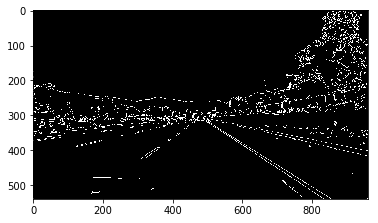

In [30]:
this_image = canny(this_image, low_threshold=50,high_threshold=100)
plt.imshow(this_image,cmap='gray')

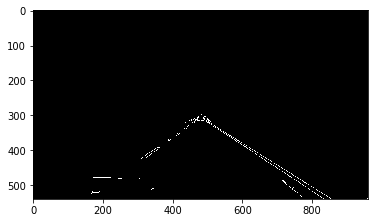

In [31]:
mask_vertices=np.array([[raw_image.shape[1]*0, raw_image.shape[0]*1],
                      [raw_image.shape[1]*.45, raw_image.shape[0]*.6],
                      [raw_image.shape[1]*.5, raw_image.shape[0]*.55],
                     [raw_image.shape[1]*1, raw_image.shape[0]*1]],
dtype=np.int32)
this_image=region_of_interest(this_image,vertices=[mask_vertices])
plt.imshow(this_image,cmap='gray')

In [32]:
def draw_lines(img, lines, color=(255, 0, 0), thickness=1):
    right_slope = []
    left_slope = []

    left_lines = []
    right_lines = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            m = ((y2-y1)/(x2-x1)) # slope
            if m < 0:
                left_slope.append(m)
                left_lines.append((x2,y2))
            else:
                right_slope.append(m)
                right_lines.append((x1,y1))
    
    right_slope = sorted(right_slope)[int(len(right_slope)/2)]
    left_slope = sorted(left_slope)[int(len(left_slope)/2)]

    left_y1 = min([line[1] for line in left_lines])
    left_pair = tuple([line[0] for line in left_lines if line[1] == left_y1] + [left_y1])

    right_y1 = min([line[1] for line in right_lines])
    right_pair = tuple([line[0] for line in right_lines if line[1] == right_y1] + [right_y1])

    left_x = int((img.shape[1]-left_pair[1])/left_slope) + left_pair[0]
    right_x = int((img.shape[1]-right_pair[1])/right_slope) + right_pair[0]
    
    cv2.line(img, left_pair, (left_x, img.shape[1]), color, thickness)
    cv2.line(img, right_pair, (right_x, img.shape[1]), color, thickness)


In [33]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
 
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=1., β=1., λ=0.):
    """
    initial_img = 1st image, α = weight of 1st image,
    img = 2nd image, β = weight of 2nd image, λ = white value
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


In [34]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [58]:
def process_image(base_img,guidance_blending=0.6):
    ysize = base_img.shape[0]
    xsize = base_img.shape[1]
    image=grayscale(raw_image)
    
    #Applying Gaussian Blur to remove noise
    image = gaussian_blur(image, 3)
    #finding edges
    image = canny(image, 30, 170)
    #setting region of interest based on our camera postion and view
    image = region_of_interest(
        image,
        np.array(
            [[(20, ysize), (xsize / 2, ysize / 2 + 20), (xsize / 2, ysize / 2 + 20), (xsize - 20, ysize)]],
            dtype=np.int32))
    image = hough_lines(image, 1.2, np.pi / 90, 5, 30, 160)
            #merging orignal image with lane marker overlay image and
    return weighted_img(image, base_img, β=guidance_blending)
    


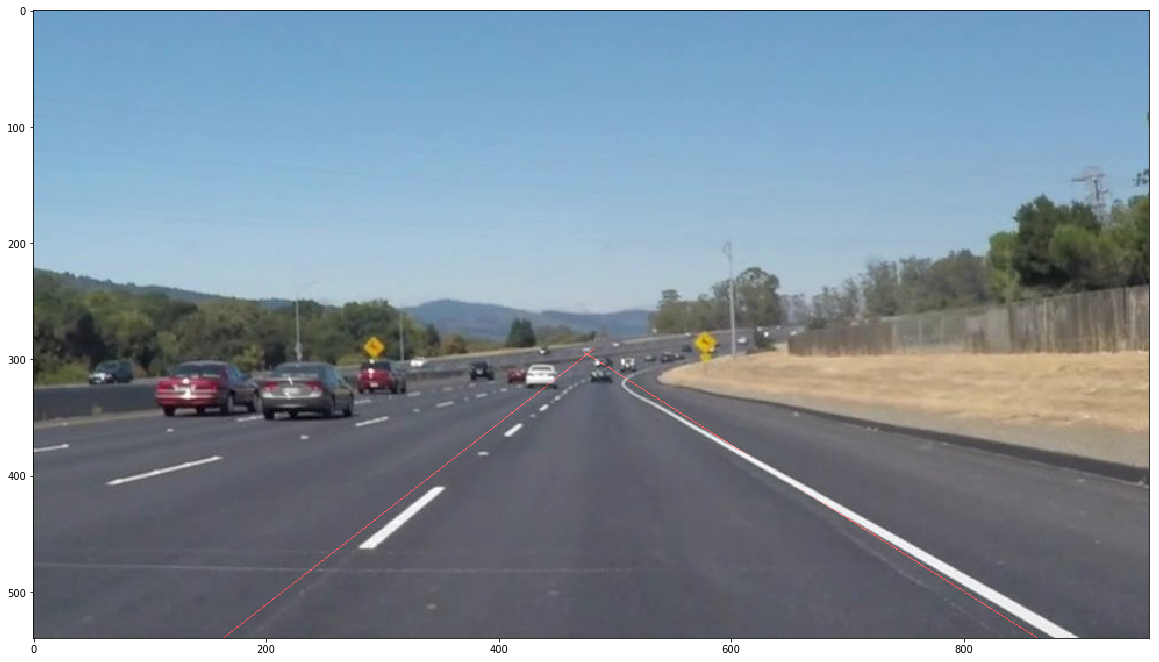

In [59]:
plt.figure(figsize=(20,20))
plt.imshow(
process_image(
mpimg.imread('test_images/solidWhiteCurve.jpg')))

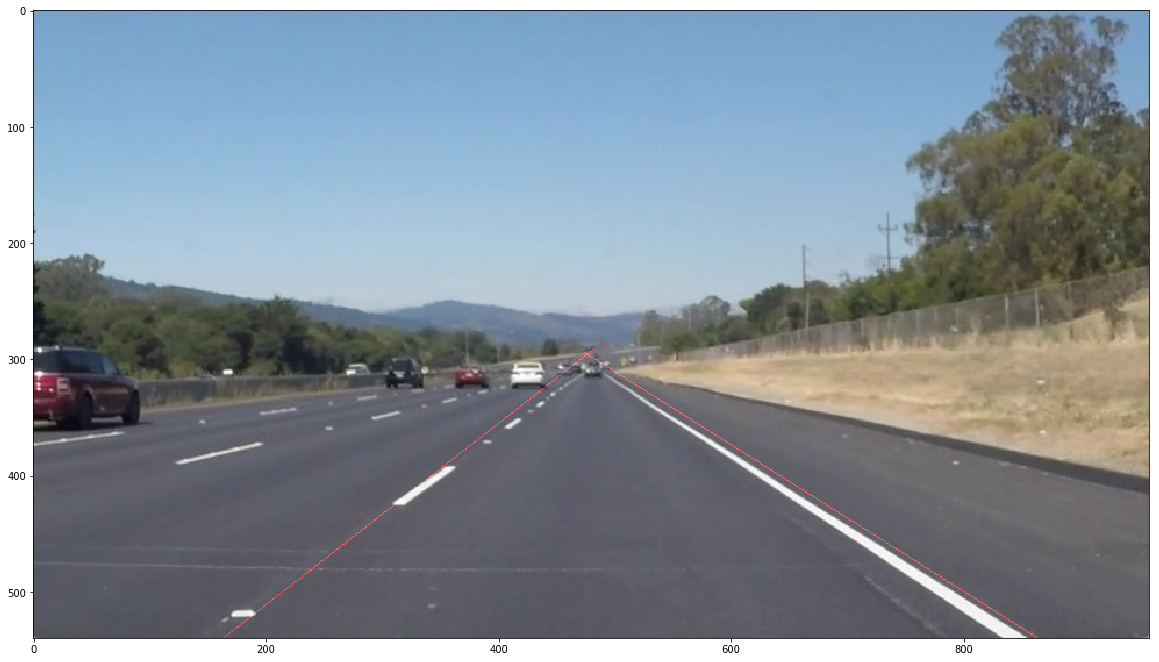

In [62]:
plt.figure(figsize=(20,20))
plt.imshow(
process_image(
mpimg.imread('test_images/solidWhiteRight.jpg')))

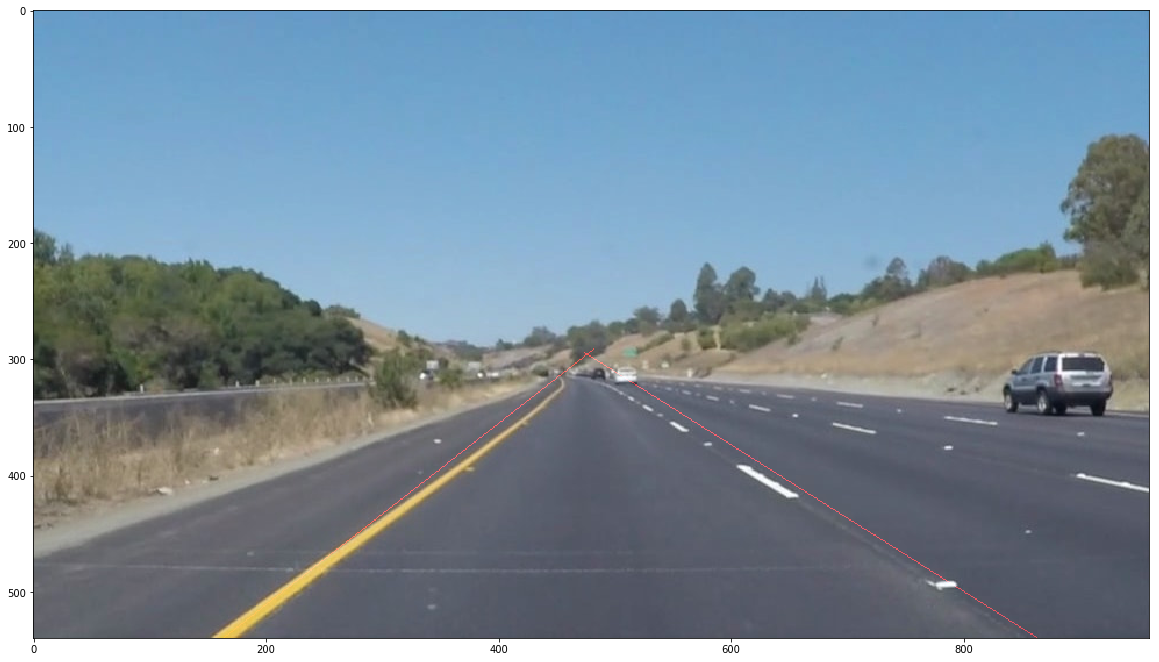

In [63]:
plt.figure(figsize=(20,20))
plt.imshow(
process_image(
mpimg.imread('test_images/solidYellowCurve.jpg')))

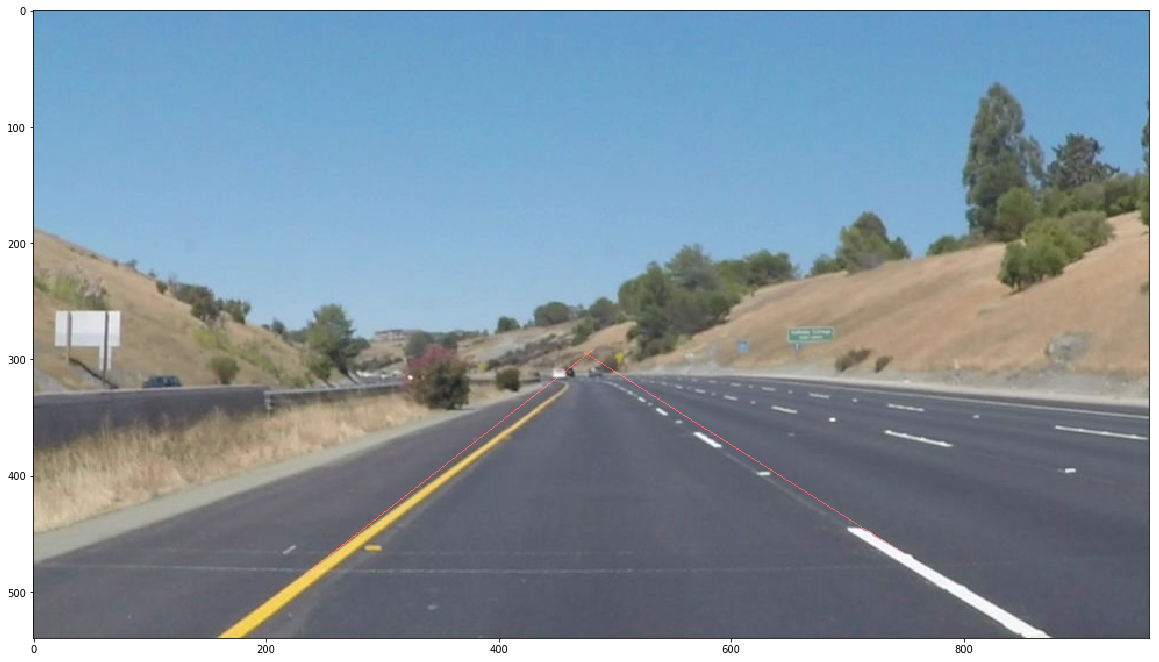

In [64]:
plt.figure(figsize=(20,20))
plt.imshow(
process_image(
mpimg.imread('test_images/solidYellowCurve2.jpg')))

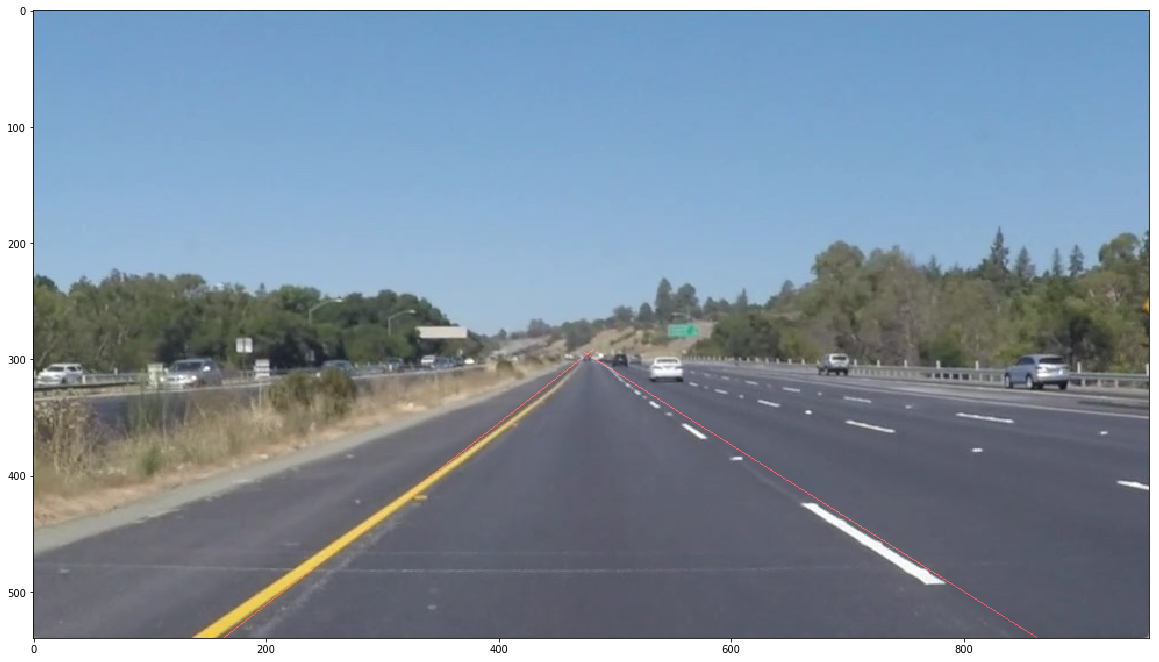

In [65]:
plt.figure(figsize=(20,20))
plt.imshow(
process_image(
mpimg.imread('test_images/solidYellowLeft.jpg')))

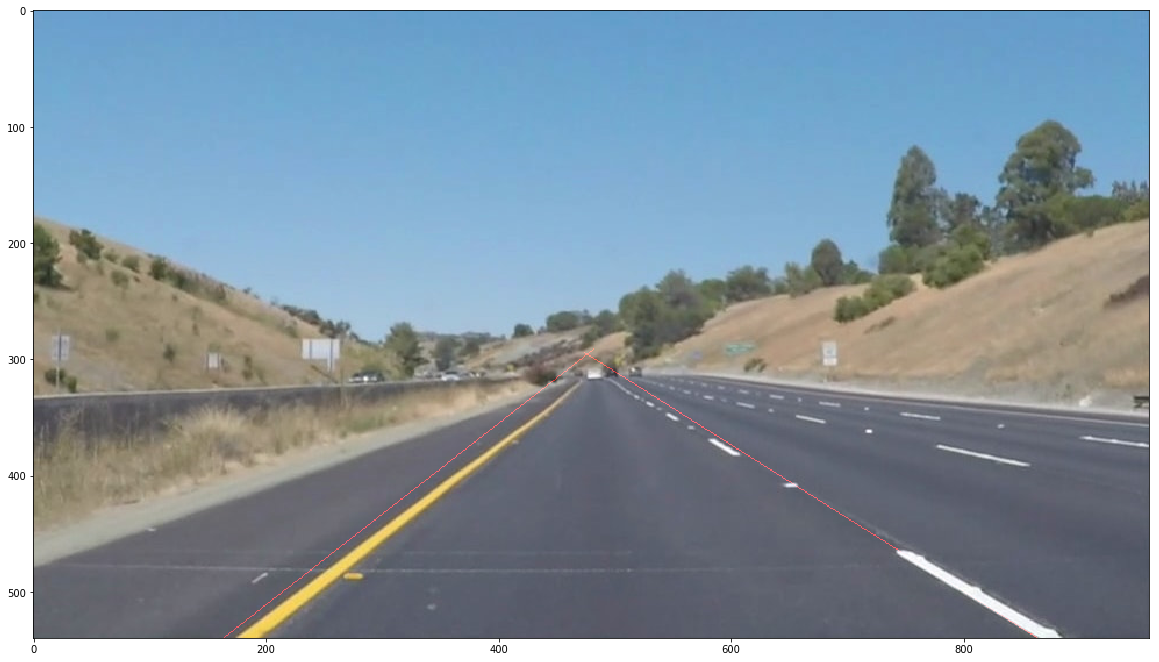

In [66]:
plt.figure(figsize=(20,20))
plt.imshow(
process_image(
mpimg.imread('test_images/WhiteCarLaneSwitch.jpg')))

In [67]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [68]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:02<00:00, 83.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 3.02 s


In [70]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [71]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:08<00:00, 85.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 8.39 s


In [72]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))